In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pertpy as pt
import scanpy as sc

import warnings
warnings.filterwarnings("ignore")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Note for benchmark: Not a fair comparison if presto not installed? -> Much faster implementation of Wilcoxon Rank Sum Test

# Run Mixscape in pertpy

In [61]:
mdata = pt.dt.papalexi_2021()
sc.pp.highly_variable_genes(mdata["rna"], n_top_genes=2000, flavor='seurat_v3', subset=True)
sc.pp.normalize_total(mdata["rna"])
sc.pp.log1p(mdata["rna"])

mdata["rna"].layers["scaled"] = mdata["rna"].X.copy()
sc.pp.scale(mdata["rna"], layer="scaled")
sc.pp.pca(mdata["rna"], n_comps=50, layer="scaled")

/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


In [62]:
#mdata["rna"].obsm["X_pca"] = np.genfromtxt("/Users/mamba/Desktop/PCA_embeddings.csv", delimiter=",", skip_header=1, usecols=range(1, 50))

mixscape_identifier = pt.tl.Mixscape()
mixscape_identifier.perturbation_signature(
    mdata["rna"], "perturbation", "NT", "replicate", n_neighbors=20, n_dims=40,
)

/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scipy/sparse/_index.py:136: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scipy/sparse/_index.py:136: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scipy/sparse/_index.py:136: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [51]:
orig_pert_signature = pd.read_csv("/Users/mamba/Desktop/PRTB_results.csv", index_col=0)
orig_pert_signature = orig_pert_signature.T.loc[mdata["rna"].obs_names, mdata["rna"].var_names]

Text(0, 0.5, 'Pertpy Perturbation Signature')

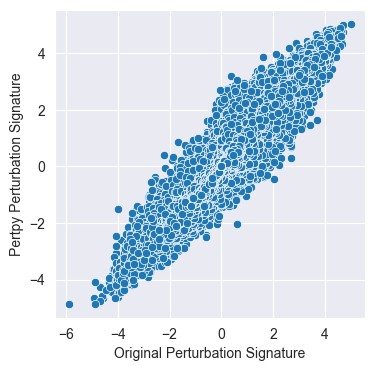

In [63]:
#mdata["rna"].layers["X_pert"] = orig_pert_signature.values

#Correlation between original and pertpy perturbation signature
plt.figure(figsize=(4, 4))
sns.scatterplot(x=orig_pert_signature.values.flatten(), y=mdata["rna"].layers["X_pert"].A.flatten())
plt.xlabel("Original Perturbation Signature")
plt.ylabel("Pertpy Perturbation Signature")

In [64]:
mixscape_identifier.mixscape(
    adata=mdata["rna"], control="NT", labels="gene_target", layer="X_pert"
)

/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scan

In [65]:
mixscape_identifier.lda(
    adata=mdata["rna"], control="NT", labels="gene_target", layer="X_pert"
)

/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy-env/lib/python3.11/site-packages/scan

# Load Mixscape results

In [66]:
#adata_pertpy = ad.read_h5ad('output/mixscape_pertpy_15dims.h5ad')
adata_pertpy = mdata["rna"]
adata_pertpy

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'mixscape', 'mixscape_lda'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'scaled', 'X_pert'

In [67]:
adata_original = ad.read_h5ad('output/mixscape_original.h5ad')
adata_original

AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nFeature_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'MULTI_classification', 'MULTI_classification.global', 'HTO_classification', 'guide_ID', 'guide_ID.global', 'gene', 'con', 'NT', 'crispr', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'mixscape_class', 'mixscape_class_p_ko', 'mixscape_class.global'
    var: 'features'
    obsm: 'X_prtbpca', 'X_prtbumap', 'X_umap'
    varm: 'PRTBPCA'

# Mixscape class comparison

In [68]:
np.all(adata_pertpy.obs_names == adata_original.obs_names)

True

In [69]:
np.all(sorted(adata_pertpy.var_names) == sorted(adata_original.var_names))

True

In [70]:
class_pertpy = adata_pertpy.obs["mixscape_class_global"]
class_original = adata_original.obs["mixscape_class.global"]

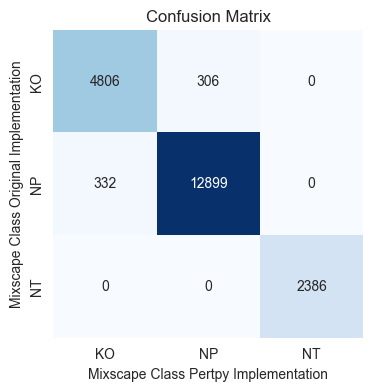

In [71]:
cm = confusion_matrix(class_original, class_pertpy)
unique_classes = sorted(class_original.unique())
cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)

plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Mixscape Class Pertpy Implementation")
plt.ylabel("Mixscape Class Original Implementation")
plt.title("Confusion Matrix")
plt.show()

# Mixscape Score comparison

In [30]:
#TODO: Correlate scores per gene?

In [58]:
# Get genes for which scores are available, i.e. genes for which mixscape identified some KO cells
genes = adata_pertpy.uns["mixscape"].keys()
genes

dict_keys(['BRD4', 'CUL3', 'IFNGR1', 'IFNGR2', 'IRF1', 'JAK2', 'MYC', 'SMAD4', 'SPI1', 'STAT1', 'STAT2'])

In [7]:
adata_pertpy.uns["mixscape"]["BRD4"]["all"]

,pvec,gene_target
l1_AAACGGGAGACAGAGA,1.488995,NT
l1_AAAGCAACAGTGGAGT,1.880040,NT
l1_AAAGTAGAGGATCGCA,0.319875,NT
l1_AACCATGGTCTCTCTG,1.131573,BRD4
l1_AACGTTGCAGGTGGAT,2.120334,BRD4
...,...,...
l8_TTTCCTCTCAGCAACT,0.865239,NT
l8_TTTGGTTGTTCCTCCA,1.707295,NT
l8_TTTGGTTTCGACCAGC,3.147430,NT
l8_TTTGTCAAGTTACGGG,0.993354,NT


In [9]:
#Get position of BRD4 in the adata_pertpy.var_names
adata_pertpy.var_names.get_loc("BRD4")

KeyError: 'BRD4'

In [ ]:
adata_pertpy.var_names

In [8]:
adata_pertpy.layers["X_pert"][adata_pertpy.var_names.]

<20729x1917 sparse matrix of type '<class 'numpy.float32'>'
	with 31264130 stored elements in Compressed Sparse Column format>

In [60]:
keys = []
for gene in adata_pertpy.uns["mixscape"].keys():
    keys.extend(adata_pertpy.uns["mixscape"][gene].keys())
keys = list(set(keys))
keys

['all']

In [61]:
csv_dir = "output/gene_csv_files"
prtb_score_dict = {}

# Iterate over each file in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith(".csv"):
        gene_name = filename.replace(".csv", "")
        
        # Load the CSV file into a pandas DataFrame
        file_path = os.path.join(csv_dir, filename)
        prtb_score_dict[gene_name] = pd.read_csv(file_path, index_col=0)

prtb_score_dict.keys()

dict_keys(['NT', 'CUL3', 'MARCH8', 'CD86', 'IFNGR1', 'UBE2L6', 'NFKBIA', 'POU2F2', 'IFNGR2', 'JAK2', 'ATF2', 'IRF7', 'STAT1', 'SMAD4', 'CAV1', 'STAT2', 'STAT3', 'BRD4', 'IRF1', 'PDCD1LG2', 'MYC', 'STAT5A', 'TNFRSF14', 'SPI1', 'ETV7', 'CMTM6'])

In [62]:
prtb_score_dict["SPI1"]

,con1.pvec,con1.gene
l1_ACTGCTCGTCACCTAA,0.456143,SPI1
l1_CGAGCACCATTGGTAC,0.341470,SPI1
l1_CTACACCGTACCAGTT,5.491969,SPI1
l1_GCACATACAATGAAAC,0.020769,SPI1
l1_GTGTTAGTCGTAGGTT,0.011281,SPI1
...,...,...
l8_TTTCCTCTCAGCAACT,0.291665,NT
l8_TTTGGTTGTTCCTCCA,-0.237432,NT
l8_TTTGGTTTCGACCAGC,0.183291,NT
l8_TTTGTCAAGTTACGGG,-0.400810,NT


In [66]:
from sklearn.metrics import mean_squared_error
for gene in genes:
    # Correlate scores per gene
    scores_pertpy = adata_pertpy.uns["mixscape"][gene]["all"]
    scores_original = prtb_score_dict[gene]
    # Bring scores into same order
    scores_original = scores_original.loc[scores_pertpy.index]
    
    mse = mean_squared_error(scores_pertpy["pvec"], scores_original["con1.pvec"])
    pcc = np.corrcoef(scores_pertpy["pvec"], scores_original["con1.pvec"])[0, 1]
    print(f"Gene: {gene}, MSE: {mse}, PCC: {pcc}")

Gene: BRD4, MSE: 1.9131894078246228, PCC: 0.7262476479528126
Gene: CUL3, MSE: 2.653430247498101, PCC: 0.4250236373923599
Gene: IFNGR1, MSE: 1.0429453351003748, PCC: 0.9287463641568469
Gene: IFNGR2, MSE: 0.9620993243381074, PCC: 0.9220216839494504
Gene: IRF1, MSE: 1.3520866589263125, PCC: 0.901703483837578
Gene: JAK2, MSE: 0.8113150669406988, PCC: 0.9220939628574059
Gene: MYC, MSE: 2.701684380780317, PCC: 0.10538538820169567
Gene: SMAD4, MSE: 1.4844293288861876, PCC: 0.7556202633993717
Gene: SPI1, MSE: 0.7961745708727179, PCC: 0.22735856844237978
Gene: STAT1, MSE: 0.42424455623110546, PCC: 0.9195427678416199
Gene: STAT2, MSE: 0.3887051184382416, PCC: 0.9358624899757132
